### IMPORTING THE DATA

In [3]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 11.3MB/s 
     |████████████████████████████████| 9.5MB 47.7MB/s 
     |████████████████████████████████| 2.1MB 48.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [4]:
import pandas as pd
from pmdarima import auto_arima
data=pd.read_csv('Light_Rail_Patronage.csv',parse_dates=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          630 non-null    object
 1   MyWay         630 non-null    int64 
 2   Paper Ticket  630 non-null    int64 
 3   Total         630 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.8+ KB


### SORTING THE DATES

In [5]:
x=[]
y=[]
z=[]
for i in data['Date'].str.split('/'):
        x.append(i[0])
        y.append(i[1])
        z.append(i[2])
d=pd.DataFrame([x,y,z])
d=d.T
s=[]
for i,j,k in zip(d[0],d[1],d[2]):
    s.append(pd.Timestamp(day=int(i),month=int(j),year=int(k)))
data['Date']=s
data=data.sort_values('Date')

### PLOTTING THE TOTAL PATRONAGE

Text(0, 0.5, 'NO OF PATRONAGE')

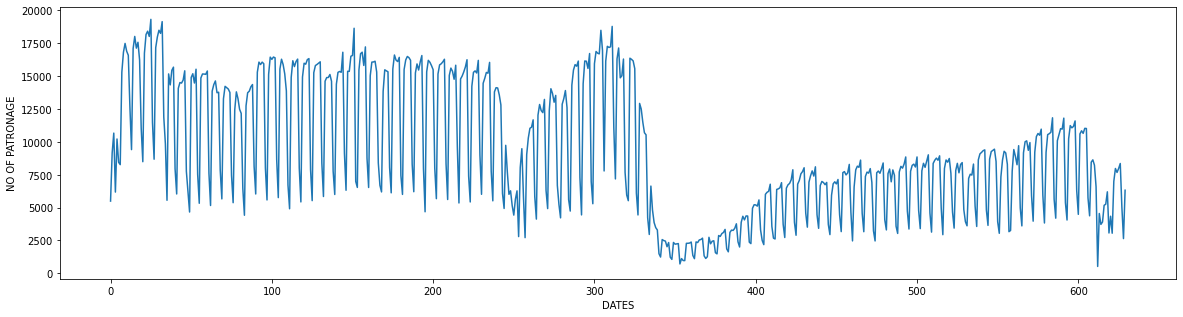

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot([i for i in range(0,630)],data['Total'])
plt.xlabel('DATES')
plt.ylabel('NO OF PATRONAGE')

In [7]:
train=data['Total'][0:623]
test=data['Total'][623:630]

### EXPONENTIAL SMOOTHING MODEL

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model=ExponentialSmoothing(train,trend='add',seasonal='mul',seasonal_periods=7).fit()
exponential_predictions=model.forecast(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


### SOME PREPROCESS FOR ARIMA

### CHECKING THE SEASONALITY AND TREND USING ETS DECOMPOSE[ERROR TREND SEASONALITY]

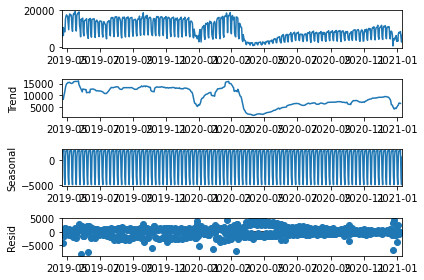

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
data=data[['Total','Date']]
data=data.set_index('Date')
data.index=pd.to_datetime(data.index)
data=data.asfreq('d')
data=data.fillna(method='bfill')
seasonal=seasonal_decompose(data,model='additive')
seasonal.plot();

###PLOTTING ACF AND PACF PLOTS

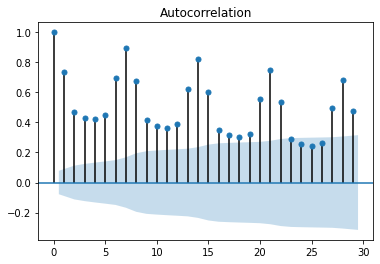

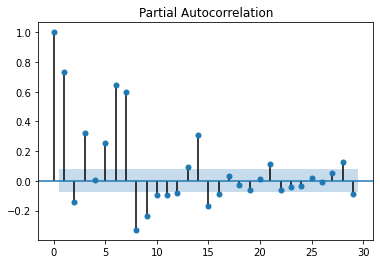

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data['Total']);
plot_pacf(data['Total']);

### TEST FOR STATIONARITY [AUGMENT DICKEY-FULLER TEST] 

In [11]:
from statsmodels.tsa.stattools import adfuller
adfuller(data['Total'])

(-2.105765191632386,
 0.2422027172345419,
 20,
 610,
 {'1%': -3.441115625417986,
  '10%': -2.56929951625907,
  '5%': -2.866289751785392},
 10744.322551779887)

The p(0.173) > 0.05 so the Total patronage data is following non stationary

we can calculate arima parameters [p,d,q] by above plots and test.But we have another method auto arima to calculate a best parameters for us

In [12]:
import warnings
warnings.filterwarnings('ignore')

### AUTO ARIMA

In [13]:
from pmdarima import auto_arima
ar=auto_arima(data['Total'],startp=0,startq=0,max_p=5,max_q=5,seasonal=True,trace=True,m=7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=11269.352, Time=2.72 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12111.141, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11718.682, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12109.142, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=11562.595, Time=2.44 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=11321.576, Time=2.23 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=11272.756, Time=4.75 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=11273.214, Time=4.59 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=11723.381, Time=1.13 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=11459.337, Time=3.07 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=11234.681, Time=4.36 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=11233.689, Time=3.24 sec
 ARIMA(2,1,1)(1,0,0)[7] intercep

In [14]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  631
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -5550.471
Date:                             Tue, 12 Jan 2021   AIC                          11112.942
Time:                                     13:09:12   BIC                          11139.617
Sample:                                          0   HQIC                         11123.303
                                             - 631                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5038      0.025    -20.419      0.000      -0.552      -0.455
ma.L2         -0.1238      0.032     -3.922      0.000      -0.186      -0.062
ar.S.L7        1.2007      0.039     30.574      0.000       1.124       1.278
ar.S.L14      -0.2058      0.038     -5.467      0.000      -0.280      -0.132
ma.S.L7       -0.8251      0.035    -23.840      0.000      -0.893      -0.757
sigma2      2.645e+06   3.86e-09   6.86e+14      0.000    2.65e+06    2.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              3218.24
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.37e+30. Standard errors may be unstable.
"""

By above summary we can conclude that the best values  parameters [p,d,q]=[0,1,1] 

###ARIMA MODEL

In [15]:
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
model=ARIMA(train,order=(0,1,1)).fit()
start=len(train)
end=len(train)+len(test)-1
Arima_predictions=model.predict(start,end)

###SARIMA MODEL [SEASONAL AUTO REGGRESSIVE INTEGRATED MOVING AVERAGE]

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train,order=(0, 1, 1),seasonal_order=(1, 0, 2, 7)).fit()
Sarima_predictions=model.predict(start,end)

###RECURREENT NEURAL NETWORK MODEL

PREPROCESSING

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [18]:
scaler=MinMaxScaler()
scaler.fit(np.array(train).reshape(-1,1))
x_train=scaler.transform(np.array(train).reshape(-1,1))
x_test=scaler.transform(np.array(test).reshape(-1,1))

n_inputs=7
n_features=1

gen=TimeseriesGenerator(x_train,x_train,length=n_inputs,batch_size=1)

CREATING THE RNN

In [19]:
model=Sequential()

model.add(LSTM(100,activation='relu'))

model.add(Dense(1))

model.compile('adam',loss='mse')

FITTING RNN

In [20]:
model.fit_generator(gen,epochs=25)

Epoch 1/25
616/616 [==============================] - 3s 3ms/step - loss: 0.0634
Epoch 2/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0207
Epoch 3/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0160
Epoch 4/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0145
Epoch 5/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0174
Epoch 6/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0131
Epoch 7/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0152
Epoch 8/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0101
Epoch 9/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0129
Epoch 10/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0126
Epoch 11/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0118
Epoch 12/25
616/616 [==============================] - 2s 3ms/step - loss: 0.0153
Epoch 13/25
616/616 [====

HERE 25 EPOCHS IS ENOUGH TO GET THE MINIMUM MEAN SQUARE ERROR SO NO NEED TO ADD MORE EPOCHS

PREDICTING THE TEST VALUES

In [21]:
test_predict=[]

train_to_pred=x_train[-7:].reshape((1,n_inputs,n_features))

for i in range(len(test)):
  new_pred=model.predict(train_to_pred)[0]

  test_predict.append(new_pred)

  train_to_pred=np.append(train_to_pred[:,1:,:],[[new_pred]],axis=1)
RNN_predictions=scaler.inverse_transform(test_predict)  

In [22]:
Recurrent_predictions=[]
for i in RNN_predictions:
  Recurrent_predictions.append(i[0])

###PLOTTING THE RESULTS


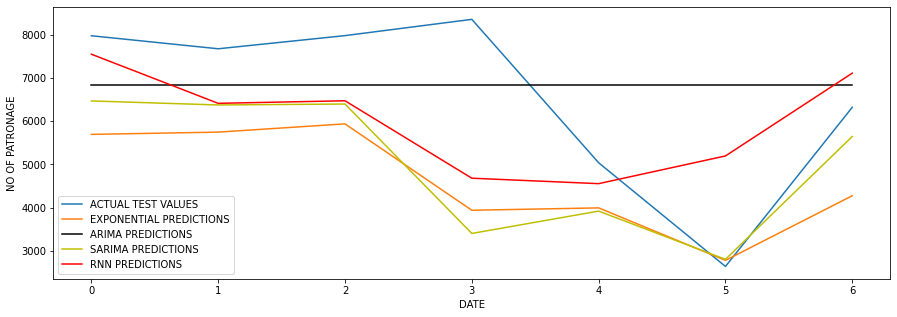

In [23]:
x=[i for i in range(7)]
plt.figure(figsize=(15,5))
plt.plot(x,test,label='ACTUAL TEST VALUES')
plt.plot(x,exponential_predictions,label='EXPONENTIAL PREDICTIONS')
plt.plot(x,Arima_predictions,label='ARIMA PREDICTIONS',color='k')
plt.plot(x,Sarima_predictions,label='SARIMA PREDICTIONS',color='y')
plt.plot(x,Recurrent_predictions,label='RNN PREDICTIONS',color='r')
plt.xlabel('DATE')
plt.ylabel('NO OF PATRONAGE')
plt.legend()

### MODEL SELECTION

In [24]:
from statsmodels.tools.eval_measures import mse,rmse,meanabs
print('ROOT MEAN SQUARE ERRORS\nEXPONENTIAT SMOOTHING = {}\nARIMA MODEL = {}\nSARIMA MODEL = {}\nRNN MODEL = {}'.format(rmse(test,exponential_predictions),rmse(test,Arima_predictions),rmse(test,Sarima_predictions),rmse(test,Recurrent_predictions)))

ROOT MEAN SQUARE ERRORS
EXPONENTIAT SMOOTHING = 2324.881837386394
ARIMA MODEL = 1951.936449161316
SARIMA MODEL = 2160.7775063897257
RNN MODEL = 1886.3051596046164


In [25]:
def confidence_interval(s):
  m=np.mean(s)
  st=np.std(s)
  #z score for 95% CI is 1.96
  upper_limit=m+(1.96*(st/np.sqrt(len(s))))
  lower_limit=m-(1.96*(st/np.sqrt(len(s))))
  return (lower_limit,upper_limit)
aa=confidence_interval(exponential_predictions)
bb=confidence_interval(Arima_predictions)
cc=confidence_interval(Sarima_predictions)
dd=confidence_interval(Recurrent_predictions)
print('COFIDENCE INTERVALS\nEXPONENTIAT SMOOTHING = {}\nARIMA MODEL = {}\nSARIMA MODEL = {}\nRNN MODEL = {}'.format(aa,bb,cc,dd))

COFIDENCE INTERVALS
EXPONENTIAT SMOOTHING = (3807.3915091244385, 5440.864353721416)
ARIMA MODEL = (6829.121567460556, 6829.121567460556)
SARIMA MODEL = (3919.538936799025, 6083.675328941075)
RNN MODEL = (5179.874730694108, 6811.769249689765)


ROOT MEAN SQUARE ERROR OF ARIMA MODEL IS LOWER THAN OTHER MODELS SO WE CONCLUDE THAT ARIMA IS BEST MODEL

SO NOW WE CAN PREDICT THE NEXT 7 DAYS PATRONAGE TOTAL

In [26]:
b_model=ARIMA(data['Total'],order=(0,1,1)).fit()
future_predictions=b_model.predict(631,637)
future_predictions

2021-01-12    6176.701505
2021-01-13    6176.701505
2021-01-14    6176.701505
2021-01-15    6176.701505
2021-01-16    6176.701505
2021-01-17    6176.701505
2021-01-18    6176.701505
Freq: D, Name: predicted_mean, dtype: float64

### Above the prediction of future 7 days total no of patronages

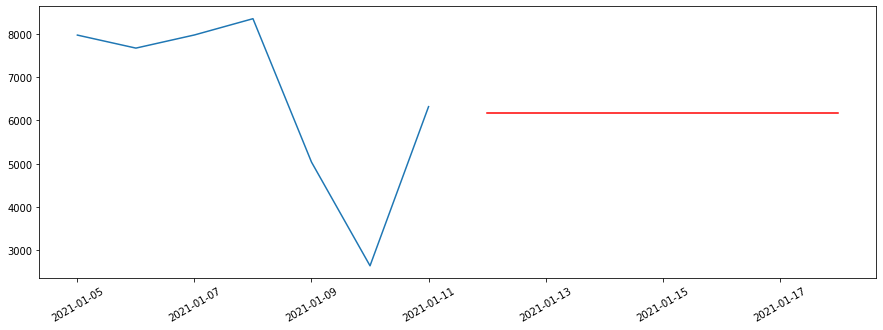

In [27]:
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as dates
plt.figure(figsize=(15,5))
left = dt.date(2021, 1, 5)
right = dt.date(2021, 1, 20)
dates1 =dates.date2num(list(pd.date_range(start='1/5/2021', end='1/11/2021')))
plt.plot_date(dates1, data['Total'][-7:],'-')
dates2 =dates.date2num(list(pd.date_range(start='1/12/2021', end='1/18/2021')))
plt.plot_date(dates2,future_predictions ,'r-')
plt.gca().xaxis.set_tick_params(rotation = 30)

###FINAL RESULT

In [28]:
final=pd.DataFrame(future_predictions)
a=[int(i) for i in future_predictions]
final.rename(columns={'predicted_mean':'TOTAL PATRONAGE'},inplace=True)
final.index.name='DATES'
final['TOTAL PATRONAGE']=a
final

,TOTAL PATRONAGE
DATES,
2021-01-12,6176
2021-01-13,6176
2021-01-14,6176
2021-01-15,6176
2021-01-16,6176
2021-01-17,6176
2021-01-18,6176


###SO WE CAN CONCLUDE THAT WE WILL EXPECT AVERAGE OF 6176 TOTAL PATRONAGE FOR FUTURE 7 DAYS

###                         !!! THANK YOU !!!